In [2]:
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
fpath = "/home/b/Downloads/plotholes-4daba-export.json"
with open (fpath) as f:
    json_content = json.loads(f.read())

In [118]:
start_time_list = []
all_acc_df = {}
all_gyro_df = {}

for key in json_content:
    val = json_content[key]
    acc_readings = json.loads(val.get('acc',[]))    
    if not acc_readings: 
        # Skip logs without any accelerometer readings
        continue 
    
    
    start_epoch = float(acc_readings[0]['timestamp'])    
    start_time = time.strftime('%m-%d %H:%M:%S', time.localtime(start_epoch))
    gyro_readings = json.loads(val.get('gyro',[]))
    start_time_list.append([start_time,len(acc_readings),len(gyro_readings)])
    acc_df = pd.DataFrame(acc_readings).astype(np.float32)
    gyro_df = pd.DataFrame(gyro_readings).astype(np.float32) if gyro_readings else None
    
    # Basic Viz
    # acc_df.drop(['pothhole', 'speedbreaker', 'timestamp'], axis=1, inplace=True)
    # acc_df = acc_df.astype(np.float32)
    # gyro_df = gyro_df.astype(np.float32)
    all_acc_df[start_time] = acc_df
    all_gyro_df[start_time] = gyro_df
    
start_time_list.sort(key=lambda x : x[0])
#print (len(all_readings))

In [10]:
start_time_list[-13:-12]

[['01-19 07:39:44', 259, 261]]

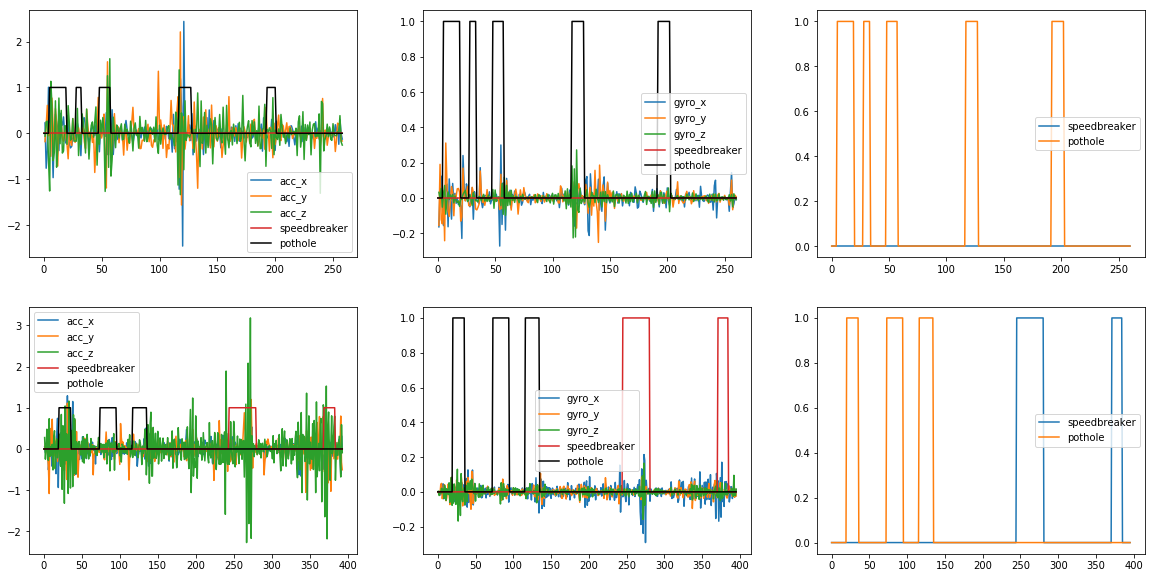

In [59]:
num_plots = 2
start_idx = -13
end_idx = -11

fig, ax = plt.subplots(num_plots, 3, figsize=(20, 10))

for i, start_time in enumerate(start_time_list[start_idx:end_idx]):
    
    start_time = start_time[0]
    viz_acc_df = all_acc_df[start_time]
    viz_gyro_df = all_gyro_df[start_time]

    ax[i,0].plot(viz_acc_df['acc_x'].diff(), label='acc_x')
    ax[i,0].plot(viz_acc_df['acc_y'].diff(), label='acc_y')
    ax[i,0].plot(viz_acc_df['acc_z'].diff(), label='acc_z')
    ax[i,0].plot(viz_acc_df['speedbreaker'], label='speedbreaker')
    ax[i,0].plot(viz_acc_df['pothhole'], label='pothole', color='black')
    ax[i,0].legend()
    
    ax[i,1].plot(viz_gyro_df['gyro_x'].diff(), label='gyro_x')
    ax[i,1].plot(viz_gyro_df['gyro_y'].diff(), label='gyro_y')
    ax[i,1].plot(viz_gyro_df['gyro_z'].diff(), label='gyro_z')
    ax[i,1].plot(viz_gyro_df['speedbreaker'], label='speedbreaker')
    ax[i,1].plot(viz_gyro_df['pothhole'], label='pothole', color='black')
    ax[i,1].legend()
    
    ax[i,2].plot(viz_gyro_df['speedbreaker'], label='speedbreaker')
    ax[i,2].plot(viz_gyro_df['pothhole'], label='pothole')
    ax[i,2].legend()

In [109]:
def extract_bad_samples(data, output_list, class_type='pothhole', window=5, stride=2):
    
    single_class = data.loc[data[class_type] == 1.0]
    diff  = np.diff(single_class.index)
    pos = np.where(diff > 1)[0] + 1
    list_of_valid_values = np.split(single_class.index, pos)
    #print(list_of_valid_values)
    data = data.drop(['pothhole', 'speedbreaker', 'timestamp'],axis=1)
    # Splitting into continguous sections
    
    for valid_values in list_of_valid_values:
        all_frames = data.loc[valid_values]
        end_idx = len(all_frames)
        for i in range(0, end_idx, stride):
            if i+window < end_idx:
                output_list.append(np.array(all_frames[i:i+window]))
    
    return output_list

In [110]:
def extract_good_samples(data, output_list, window=5, stride=2):
    
    single_class = data.loc[(data['pothhole'] == 0.0) & (data['speedbreaker'] == 0.0)]
    diff  = np.diff(single_class.index)
    pos = np.where(diff > 1)[0] + 1
    list_of_valid_values = np.split(single_class.index, pos)
    #print(list_of_valid_values)
    data = data.drop(['pothhole', 'speedbreaker', 'timestamp'],axis=1)
    # Splitting into continguous sections
    
    for valid_values in list_of_valid_values:
        all_frames = data.loc[valid_values]
        end_idx = len(all_frames)
        for i in range(0, end_idx, stride):
            if i+window < end_idx:
                output_list.append(np.array(all_frames[i:i+window]))
    
    return output_list

In [94]:
#output_list = []
#start_time = start_time_list[-13][0]
#current_acc_df = all_acc_df[start_time]
#output_list = extract_samples(current_acc_df, output_list, class_type = 'pothhole')
#output_list = extract_samples(current_acc_df, output_list, class_type = 'speedbreaker')

In [111]:
output_list = []
start_idxs = [-13, -12, -8, -6, -4, -3]

for idx in start_idxs:
    start_time = start_time_list[idx][0]
    current_acc_df = all_acc_df[start_time]
    output_list = extract_good_samples(current_acc_df, output_list)

good_road_data = np.array(output_list)

In [112]:
good_road_data.shape

(1563, 5, 3)

In [107]:
output_list = []
start_idxs = [-13, -12, -8, -6, -4, -3]

for idx in start_idxs:
    start_time = start_time_list[idx][0]
    current_acc_df = all_acc_df[start_time]
    output_list = extract_bad_samples(current_acc_df, output_list, class_type = 'pothhole')
    output_list = extract_bad_samples(current_acc_df, output_list, class_type = 'speedbreaker')

bad_road_data = np.array(output_list)

In [108]:
bad_road_data.shape

(230, 5, 3)

In [114]:
np.random.seed(42)
perm = np.random.permutation(1563)[:230]

### Model Training

In [37]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM
from keras.utils import to_categorical
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint

In [13]:
start_time_list = []
all_acc_df = {}
all_gyro_df = {}

for key in json_content:
    val = json_content[key]
    acc_readings = json.loads(val.get('acc',[]))    
    if not acc_readings: 
        # Skip logs without any accelerometer readings
        continue 
    
    
    start_epoch = float(acc_readings[0]['timestamp'])    
    start_time = time.strftime('%m-%d %H:%M:%S', time.localtime(start_epoch))
    gyro_readings = json.loads(val.get('gyro',[]))
    start_time_list.append([start_time,len(acc_readings),len(gyro_readings)])
    acc_df = pd.DataFrame(acc_readings).astype(np.float32)
    gyro_df = pd.DataFrame(gyro_readings).astype(np.float32) if gyro_readings else None
    
    # Basic Viz
    # acc_df.drop(['pothhole', 'speedbreaker', 'timestamp'], axis=1, inplace=True)
    # acc_df = acc_df.astype(np.float32)
    # gyro_df = gyro_df.astype(np.float32)
    all_acc_df[start_time] = acc_df
    all_gyro_df[start_time] = gyro_df
    
start_time_list.sort(key=lambda x : x[0])
#print (len(all_readings))

In [14]:
def extract_bad_samples(data, output_list, class_type='pothhole', window=5, stride=2):
    
    single_class = data.loc[data[class_type] == 1.0]
    diff  = np.diff(single_class.index)
    pos = np.where(diff > 1)[0] + 1
    list_of_valid_values = np.split(single_class.index, pos)
    #print(list_of_valid_values)
    data = data.drop(['pothhole', 'speedbreaker', 'timestamp'],axis=1)
    # Splitting into continguous sections
    
    for valid_values in list_of_valid_values:
        all_frames = data.loc[valid_values]
        end_idx = len(all_frames)
        for i in range(0, end_idx, stride):
            if i+window < end_idx:
                output_list.append(np.array(all_frames[i:i+window]))
    
    return output_list

def extract_good_samples(data, output_list, window=5, stride=2):
    
    single_class = data.loc[(data['pothhole'] == 0.0) & (data['speedbreaker'] == 0.0)]
    diff  = np.diff(single_class.index)
    pos = np.where(diff > 1)[0] + 1
    list_of_valid_values = np.split(single_class.index, pos)
    #print(list_of_valid_values)
    data = data.drop(['pothhole', 'speedbreaker', 'timestamp'],axis=1)
    # Splitting into continguous sections
    
    for valid_values in list_of_valid_values:
        all_frames = data.loc[valid_values]
        end_idx = len(all_frames)
        for i in range(0, end_idx, stride):
            if i+window < end_idx:
                output_list.append(np.array(all_frames[i:i+window]))
    
    return output_list

In [15]:
output_list = []
start_idxs = [-13, -12, -8, -6, -4, -3]

for idx in start_idxs:
    start_time = start_time_list[idx][0]
    current_acc_df = all_acc_df[start_time]
    output_list = extract_good_samples(current_acc_df, output_list)

good_road_data = np.array(output_list)

output_list = []
start_idxs = [-13, -12, -8, -6, -4, -3]

for idx in start_idxs:
    start_time = start_time_list[idx][0]
    current_acc_df = all_acc_df[start_time]
    output_list = extract_bad_samples(current_acc_df, output_list, class_type = 'pothhole')
    output_list = extract_bad_samples(current_acc_df, output_list, class_type = 'speedbreaker')

bad_road_data = np.array(output_list)

np.random.seed(42)
perm = np.random.permutation(1563)
good_road_data = good_road_data[perm][:230]

In [16]:
good_labels = [0 for _ in range(230)]
bad_labels = [1 for _ in range(230)]
labels = good_labels + bad_labels
labels = to_categorical(labels)
data = np.concatenate((good_road_data, bad_road_data), axis=0)
#data = data / 6 # max scaling.
#labels = np.concatenate((good_labels, bad_labels))

In [17]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.15, random_state=42)

In [18]:
trainX.shape

(391, 5, 3)

In [19]:
clear_session()
model = Sequential()
model.add(LSTM(32, input_shape=(5, 3), return_sequences=True, activation='relu'))
model.add(LSTM(128, input_shape=(5, 3), activation='relu'))
model.add(Dense(2, activation='softmax'))

In [21]:
ckpt = ModelCheckpoint('./activity.hdf5', 
                                       monitor='val_acc', 
                                       save_best_only=True)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 32)             4608      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 87,298
Trainable params: 87,298
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
model.fit(trainX, trainY, batch_size=20, epochs=100, validation_split=0.1, callbacks=[ckpt])

Train on 351 samples, validate on 40 samples
Epoch 1/100
351/351 [==============================] - 11s 32ms/step - loss: 0.6989 - acc: 0.5128 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/100
351/351 [==============================] - 0s 638us/step - loss: 0.6968 - acc: 0.5014 - val_loss: 0.6853 - val_acc: 0.6250
Epoch 3/100
351/351 [==============================] - 0s 631us/step - loss: 0.6861 - acc: 0.5840 - val_loss: 0.6806 - val_acc: 0.7000
Epoch 4/100
351/351 [==============================] - 0s 628us/step - loss: 0.6612 - acc: 0.6268 - val_loss: 0.6814 - val_acc: 0.5750
Epoch 5/100
351/351 [==============================] - 0s 625us/step - loss: 0.6268 - acc: 0.6752 - val_loss: 0.6768 - val_acc: 0.5250
Epoch 6/100
351/351 [==============================] - 0s 637us/step - loss: 0.5855 - acc: 0.6667 - val_loss: 0.6517 - val_acc: 0.6750
Epoch 7/100
351/351 [==============================] - 0s 631us/step - loss: 0.5824 - acc: 0.6781 - val_loss: 0.6426 - val_acc: 0.6750
Epoch 8/10

Epoch 61/100
351/351 [==============================] - 0s 636us/step - loss: 0.4316 - acc: 0.7635 - val_loss: 0.6886 - val_acc: 0.6250
Epoch 62/100
351/351 [==============================] - 0s 629us/step - loss: 0.4432 - acc: 0.7692 - val_loss: 0.6362 - val_acc: 0.6250
Epoch 63/100
351/351 [==============================] - 0s 624us/step - loss: 0.4447 - acc: 0.7778 - val_loss: 0.5675 - val_acc: 0.7500
Epoch 64/100
351/351 [==============================] - 0s 625us/step - loss: 0.4176 - acc: 0.7721 - val_loss: 0.6970 - val_acc: 0.6000
Epoch 65/100
351/351 [==============================] - 0s 630us/step - loss: 0.4196 - acc: 0.7863 - val_loss: 0.7508 - val_acc: 0.7000
Epoch 66/100
351/351 [==============================] - 0s 626us/step - loss: 0.4156 - acc: 0.7721 - val_loss: 0.5856 - val_acc: 0.7000
Epoch 67/100
351/351 [==============================] - 0s 628us/step - loss: 0.4015 - acc: 0.7949 - val_loss: 0.6996 - val_acc: 0.6250
Epoch 68/100
351/351 [==========================

In [25]:
output = model.predict(testX)

In [26]:
np.count_nonzero(output.argmax(axis = 1) == testY.argmax(axis = 1)) / len(testY)

0.7101449275362319

In [27]:
!wget https://github.com/amir-abdi/keras_to_tensorflow/archive/master.zip

--2019-01-19 17:54:29--  https://github.com/amir-abdi/keras_to_tensorflow/archive/master.zip
Resolving github.com (github.com)... 13.250.177.223, 13.229.188.59, 52.74.223.119
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/amir-abdi/keras_to_tensorflow/zip/master [following]
--2019-01-19 17:54:30--  https://codeload.github.com/amir-abdi/keras_to_tensorflow/zip/master
Resolving codeload.github.com (codeload.github.com)... 54.251.140.56, 13.250.162.133, 13.229.189.0
Connecting to codeload.github.com (codeload.github.com)|54.251.140.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ]  12.03K  --.-KB/s    in 0.05s   

2019-01-19 17:54:31 (225 KB/s) - ‘master.zip’ saved [12322]



In [28]:
!unzip master.zip

Archive:  master.zip
24c4f8d715148a42690e8cd089bfe5eeeed3a8ea
   creating: keras_to_tensorflow-master/
  inflating: keras_to_tensorflow-master/.gitignore  
  inflating: keras_to_tensorflow-master/LICENSE  
  inflating: keras_to_tensorflow-master/README.md  
  inflating: keras_to_tensorflow-master/keras_to_tensorflow.py  
   creating: keras_to_tensorflow-master/legacy/
  inflating: keras_to_tensorflow-master/legacy/freeze_graph.py  
  inflating: keras_to_tensorflow-master/legacy/keras_to_tensorflow.ipynb  
  inflating: keras_to_tensorflow-master/legacy/keras_to_tensorflow_via_freeze_graph.ipynb  
 extracting: keras_to_tensorflow-master/requirements.txt  


In [29]:
ls

activity.hdf5                     Extract and Model.ipynb      master.zip
Data Loading and Cleansing.ipynb  keras_to_tensorflow-master/  Untitled.ipynb


In [34]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [35]:
!python ./keras_to_tensorflow-master/keras_to_tensorflow.py \
    --input_model="./activity.hdf5" \
    --output_model="./activity.pb"

/home/b/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
2019-01-19 18:00:09.584582: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-01-19 18:00:09.588483: E tensorflow/stream_executor/cuda/cuda_driver.cc:397] failed call to cuInit: CUDA_ERROR_NO_DEVICE
2019-01-19 18:00:09.588518: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] retrieving CUDA diagnostic information for host: man
2019-01-19 18:00:09.588527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:170] hostname: man
2019-01-19 18:00:09.588555: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:194] libcuda reported version is: 384.13

In [36]:
ls

activity.hdf5                     Extract and Model.ipynb      Untitled.ipynb
activity.pb                       keras_to_tensorflow-master/
Data Loading and Cleansing.ipynb  master.zip


In [38]:
clear_session()
path = 'activity.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [40]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        #print(tf.get_default_graph().get_operations())
        x = tf.get_default_graph().get_tensor_by_name('lstm_1_input:0')
        y = tf.get_default_graph().get_tensor_by_name('dense_1/Softmax:0')
        
        prediction2 = sess.run(y, feed_dict={x: testX})

In [42]:
np.count_nonzero(prediction2.argmax(axis = 1) == testY.argmax(axis = 1)) / len(testY)

0.7246376811594203

In [44]:

converter = tf.lite.TFLiteConverter.from_saved_model('activity.pb')
tflite_model = converter.convert()
open("activity.tflite", "wb").write(tflite_model)

AttributeError: module 'tensorflow' has no attribute 'lite'

In [47]:
from tensorflow.contrib.lite import TFLiteConverter

ImportError: cannot import name 'TFLiteConverter'

In [51]:
tf.__version__

'1.10.0'

In [54]:
!tflite_convert \
  --output_file='activity.tflite' \
  --graph_def_file='activity.pb' \
  --input_arrays='lstm_1_input' \
  --output_arrays='dense_1/Softmax'

/home/b/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2019-01-19 18:31:20.221915: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-01-19 18:31:20.223110: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Traceback (most recent call last):
  File "/home/b/anaconda3/bin/tflite_convert", line 11, in <module>
    sys.exit(main())
  File "/home/b/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/lite/python/tflite_convert.py", line 320, in main
    app.run(main=run_main, argv=sys.argv[:1])
  